In [71]:
import xarray as xr
import cfgrib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd


In [72]:
grib_data = cfgrib.open_datasets('../../data2022_test.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [73]:
feature_list = ['t2m', 'tcc', 'u10', 'v10', 'tp', 'sp']
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
# tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])

tp = hybrid.tp.to_numpy()

u10.shape, tp.shape
data = np.stack((t2m, tcc, u10, v10, tp, sp), axis=-1)

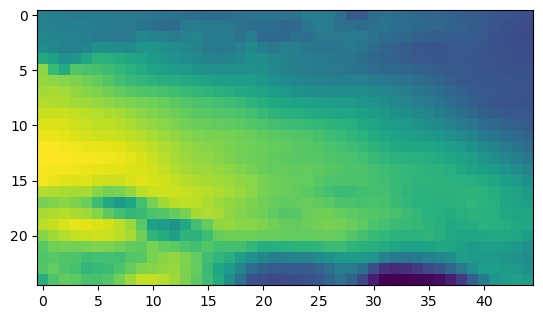

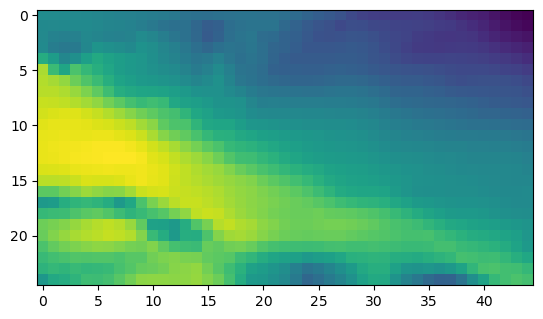

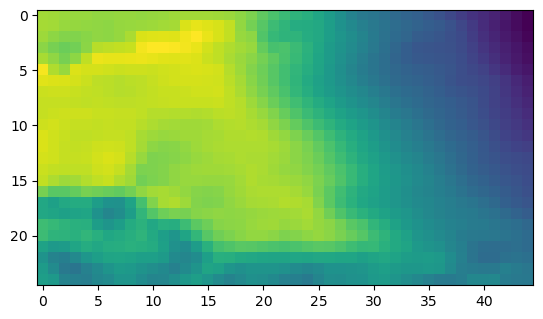

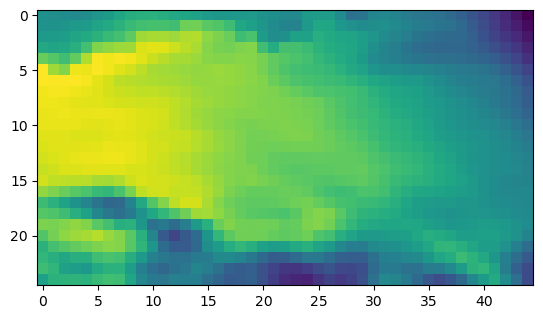

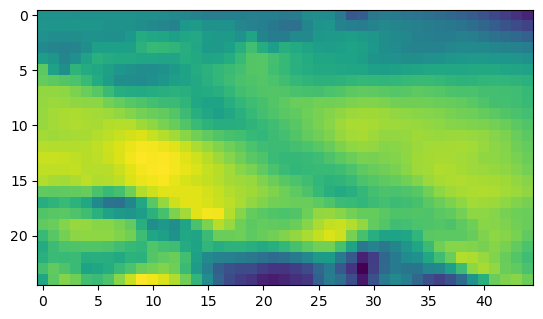

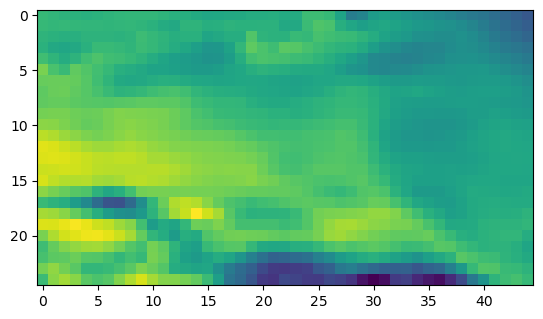

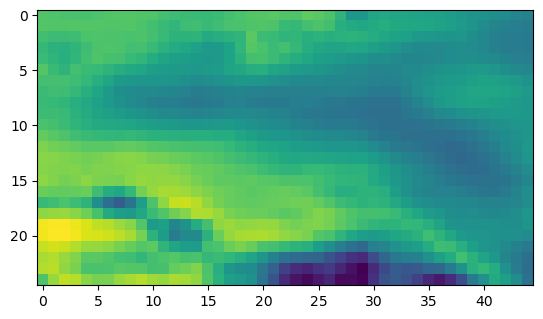

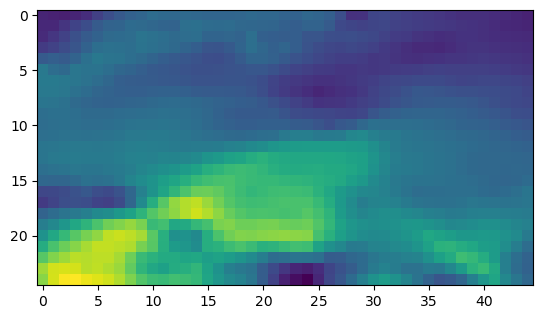

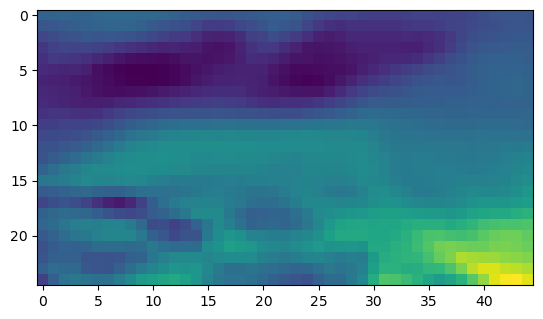

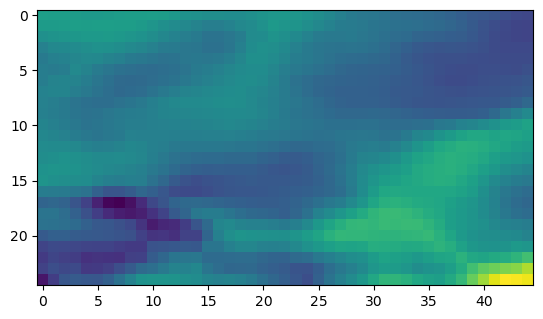

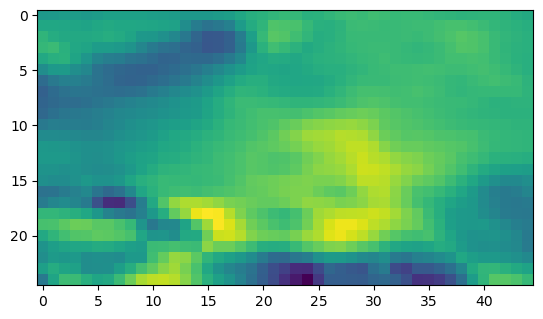

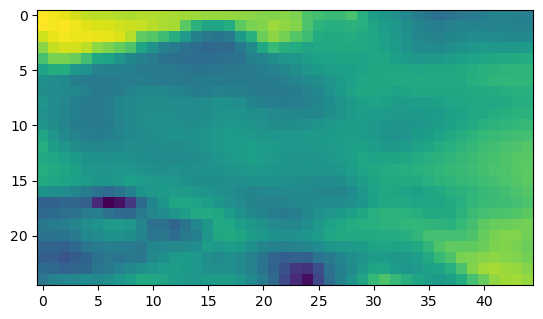

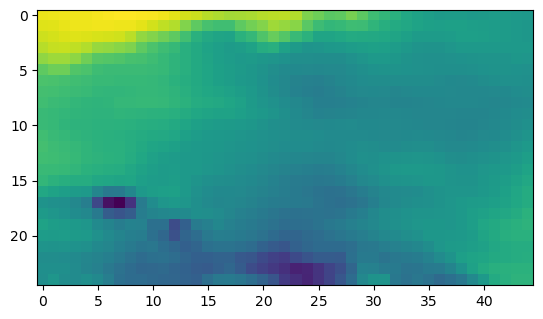

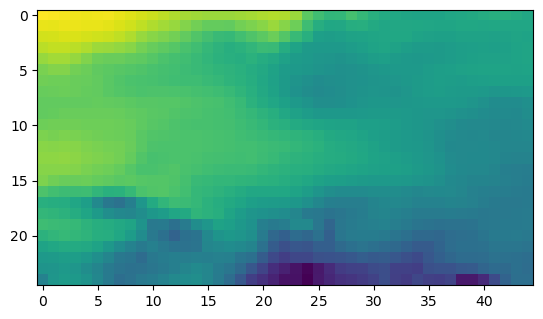

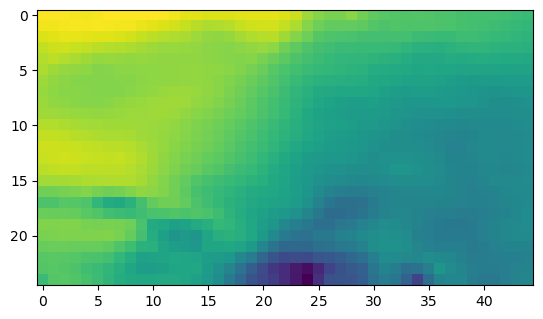

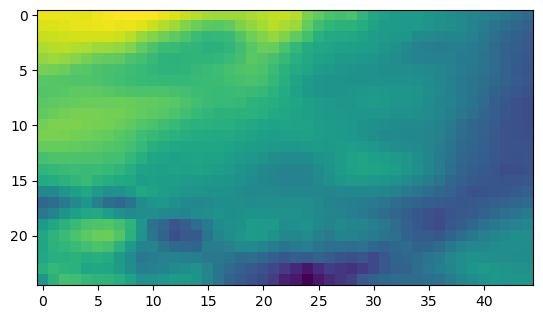

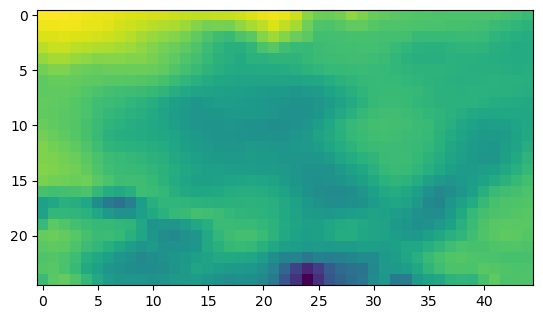

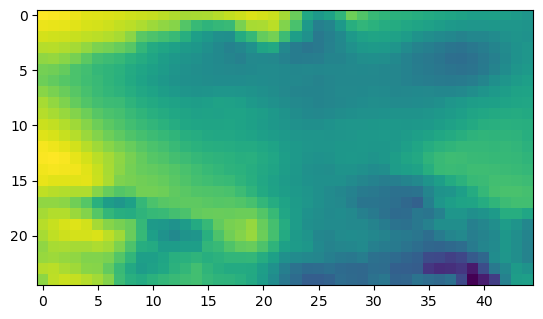

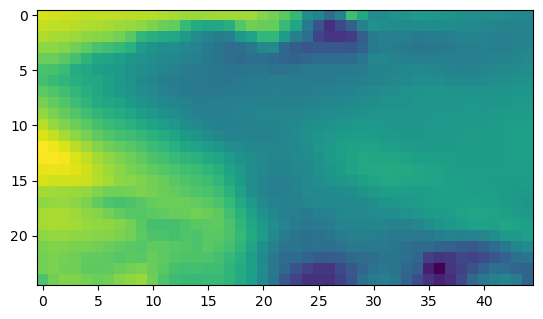

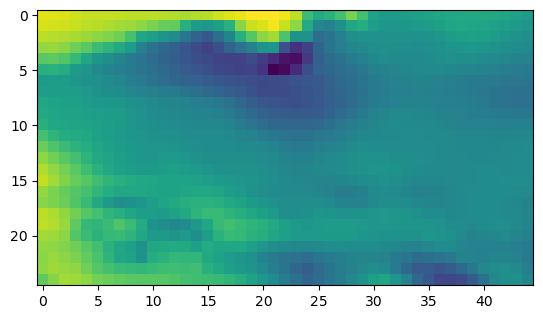

In [74]:

for i in range(20):
    plt.imshow(t2m[i])
    plt.show()

In [75]:
surface

<xarray.Dataset>
Dimensions:     (time: 730, latitude: 25, longitude: 45)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2022-01-01T06:00:00 ... 2022-12-31T18:0...
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 49.5 49.25 49.0
  * longitude   (longitude) float64 14.0 14.25 14.5 14.75 ... 24.5 24.75 25.0
    valid_time  (time) datetime64[ns] 2022-01-01T06:00:00 ... 2022-12-31T18:0...
Data variables:
    sp          (time, latitude, longitude) float32 1.016e+05 ... 9.851e+04
    tcc         (time, latitude, longitude) float32 1.0 1.0 ... 0.9639 0.9557
    u10         (time, latitude, longitude) float32 6.307 6.349 ... 5.478 4.516
    v10         (time, latitude, longitude) float32 -1.737 -1.965 ... 2.248
    t2m         (time, latitude, longitude) float32 279.3 279.2 ... 284.0 283.3
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [76]:
t2m = surface.t2m.to_numpy()
t2m.shape

(730, 25, 45)

In [77]:
hybrid

<xarray.Dataset>
Dimensions:     (time: 730, latitude: 25, longitude: 45)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2021-12-31T18:00:00 ... 2022-12-31T06:0...
    step        timedelta64[ns] 12:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 49.5 49.25 49.0
  * longitude   (longitude) float64 14.0 14.25 14.5 14.75 ... 24.5 24.75 25.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    tp          (time, latitude, longitude) float32 5.96e-05 ... 8.583e-06
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [78]:
def step_split(feature, n_steps=3):
    step_split = np.split(feature, n_steps, axis=1)
    step_split = [np.squeeze(arr, axis=1) for arr in step_split]

    return np.array(step_split)

In [79]:
#convert tigge into usable format

grib_file = '../../2022-01-01-to-2022-12-31.grib'
grib_data = cfgrib.open_datasets(grib_file)


first_step = int(grib_data[0].step[2])

tcc_tigge = grib_data[0].tcc.to_numpy()

tcc_step_0, tcc_step_6, tcc_step_12 = step_split(tcc_tigge)

u10_tigge = grib_data[1].u10.to_numpy()

u10_step_0, u10_step_6, u10_step_12 = step_split(u10_tigge)

v10_tigge = grib_data[1].v10.to_numpy()

v10_step_0, v10_step_6, v10_step_12 = step_split(v10_tigge)

t2m_tigge = grib_data[2].t2m.to_numpy()

t2m_step_0, t2m_step_6, t2m_step_12 = step_split(t2m_tigge) - 273.15

sp_tigge = grib_data[3].sp.to_numpy()

sp_step_0, sp_step_6, sp_step_12 = step_split(sp_tigge) / 100

tp_tigge = grib_data[3].tp.to_numpy()

tp_step_0, tp_step_6, tp_step_12 = step_split(tp_tigge)



data_step_0 = np.stack((t2m_step_0, tcc_step_0, u10_step_0, v10_step_0, tp_step_0, sp_step_0), axis=-1)

data_step_6 = np.stack((t2m_step_6, tcc_step_6, u10_step_6, v10_step_6, tp_step_6, sp_step_6), axis=-1)

data_step_12 = np.stack((t2m_step_12, tcc_step_12, u10_step_12, v10_step_12, tp_step_12, sp_step_12), axis=-1)



In [80]:
data_step_6.shape

(730, 25, 45, 6)

In [81]:
import sys

sys.path.append('../..')
from data_processor import DataProcessor
from baseline_regressor import  BaselineRegressor

In [82]:
tigge_processor = DataProcessor(data_step_6)
s = 3
fh = 1
X_tigge, y_tigge = tigge_processor.preprocess(s, fh)
X_tigge_train, X_tigge_test, y_tigge_train, y_tigge_test = processor.train_test_split(X_tigge, y_tigge)

In [83]:
X_tigge.shape, y_tigge.shape

((727, 25, 45, 3, 6), (727, 25, 45, 1, 6))

In [84]:
state_of_the_art = BaselineRegressor(X_tigge.shape, fh, feature_list)

In [85]:
era_processor = DataProcessor(data)
s = 3
fh = 1
X_era, y_era = era_processor.preprocess(s, fh)
X_era_train, X_era_test, y_era_train, y_era_test = processor.train_test_split(X_era, y_era)

In [86]:
X_era.shape, y_era.shape

((727, 25, 45, 3, 6), (727, 25, 45, 1, 6))

t2m => RMSE:  1.00395; SE: 0.05657412225192445
tcc => RMSE:  97.47061; SE: 0.0012024836997770278
u10 => RMSE:  0.62303; SE: 0.0425120454132074
v10 => RMSE:  0.553; SE: 0.049648375363507184
tp => RMSE:  1.18765; SE: 3.307303960752841e-06
sp => RMSE:  3.25781; SE: 0.31931345090401136


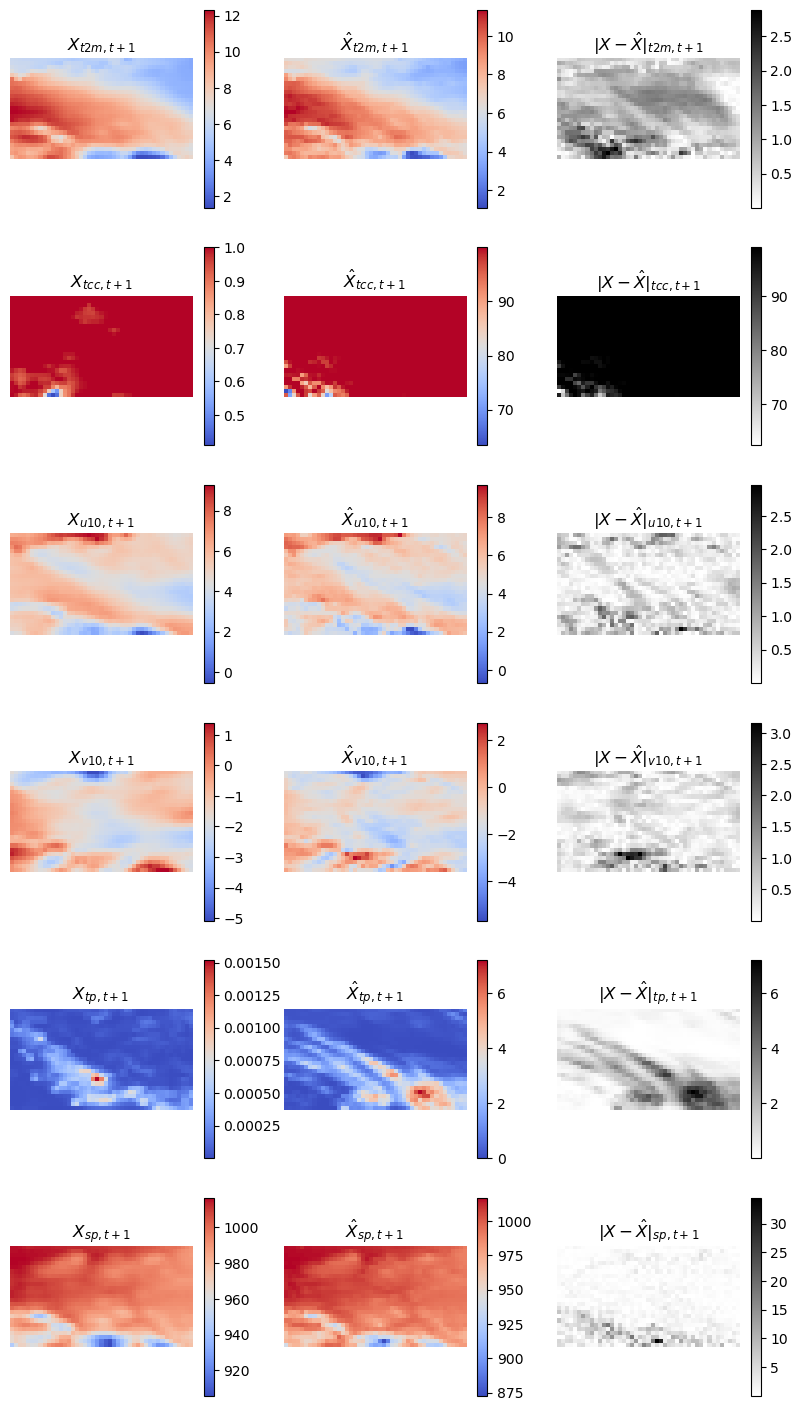

In [89]:
state_of_the_art.plot_predictions(X_tigge, X_era, max_samples=1)